# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: 
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. 
В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**
- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
csv_path = '/datasets/faces/labels.csv'
labels_df = pd.read_csv(csv_path)
print(labels_df.head())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [3]:
print("Размер выборки:", len(labels_df))

Размер выборки: 7591


In [4]:
print(labels_df['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [5]:
print(labels_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


Таким образом, размер выборки составил 7591 файлов, достаточно для обучения модели. В значениях пропуски отсутствуют.

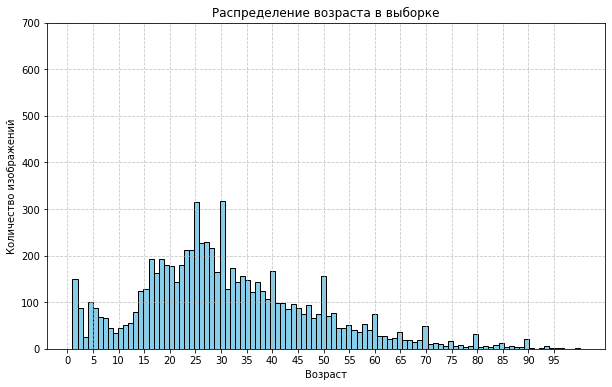

In [6]:
#составляем график
plt.figure(figsize=(10, 6))
plt.hist(labels_df['real_age'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 100, 5)) 
plt.yticks(range(0, 800, 100))  
plt.show()

На гистограмме отмечены пики на возрастах 25, 30, 40, 50, 60, 70, 80, 90. Данные выглядят таким образом, видимо, вследствии работы разметчиков, которые округляли возраст до ближайших значений, кратным десяти годам.

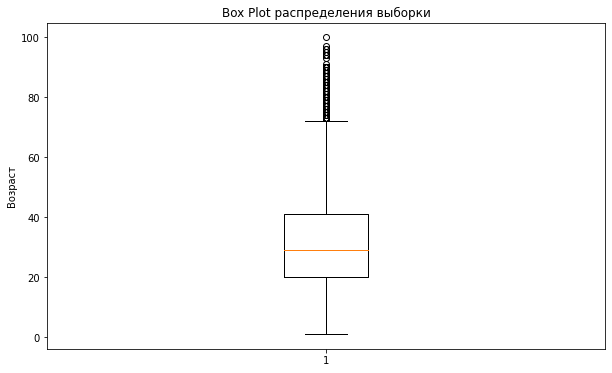

In [7]:
#посмотрим на распределение выборки
plt.figure(figsize=(10, 6))
plt.boxplot(labels_df['real_age'])
plt.title('Box Plot распределения выборки')
plt.ylabel('Возраст')
plt.show()

По графикам видно, что распределение выборки имеет смещенное распределение.
Медиана - 29 лет, первый и третий квартили - 20 и 41 год.
Минимальное значение в пределах 1.5 межквартильного размаха - 1 год, максимальное - 72 года.

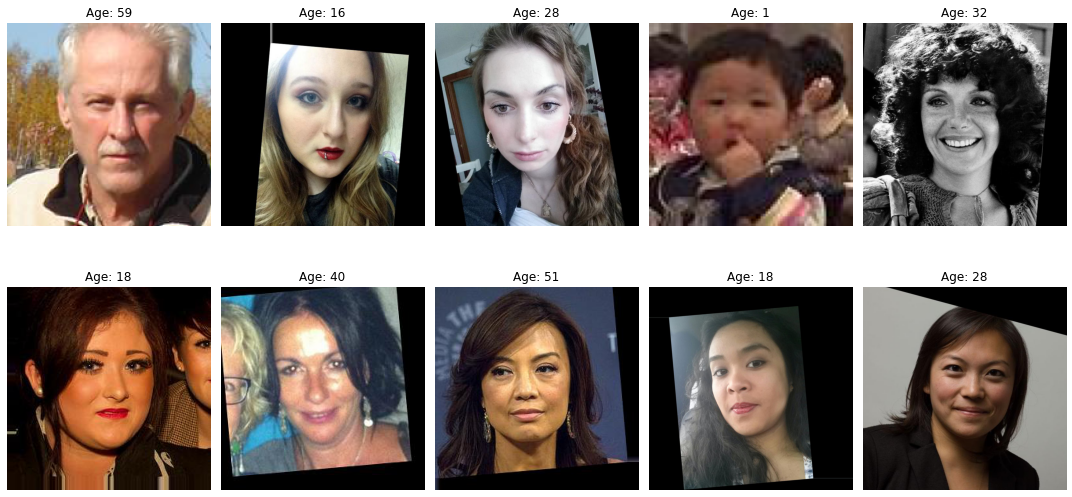

In [8]:
#выводим изображения на экран
image_dir = '/datasets/faces/final_files/'
random_indices = labels_df.sample(10).index

plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    image_path = image_dir + labels_df.loc[index, 'file_name']
    image = Image.open(image_path)
    plt.subplot(2, 5, i)
    plt.imshow(image)
    plt.title(f'Age: {labels_df.loc[index, "real_age"]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Размер выборки составил 7591. Больше всего людей в возрасте 20-25 лет, также есть пики в 35 и 45 лет. Много выбросов после 70 лет. Что касается самих фотографий, то из проблем можно обозначить наклоны фотографий, плохой свет, некачественные и нечеткие фотографии - все это может помешать модели определять правильно возраст клиентов.

**Вывод** Датасет представлен изображением и информацией о возрасте. Размер выборки составил 7591 файлов, что достаточно для обучения модели. На гистограмме были отмечены пики на возрастах 25, 30, 40, 50, 60, 70, 80, 90. Что касается самих фотографий, то из проблем можно обозначить наклоны фотографий, плохой свет, некачественные и нечеткие фотографии, есть фото в очках и закрытые лица, - все это может помешать модели определять правильно возраст клиентов. Распределение данных на графики имеет вид бимодального распределения с длинным смещенным хвостом. Медиана - 29 лет, первый и третий квартили - 20 и 41 год. Минимальное значение в пределах 1.5 межквартильного размаха - 1 год, максимальное - 72 года. Можно сказать, что модель будет обучаться на неравномернораспределенной выборке. Основная масса людей составляет 20-41 год, поэтому модель будет лучше определять данные возраст. Там, где возраст будет более 72 лет существует вероятность плохого обучения модели. Из-за качества данных, их количество недостаточно для корректного обучения, данные нужно обогатить.ч

## Обучение модели

Были написаны две функции - load_train и load_test. В первой функции загружаются данные для обучения, во воорой данные для тестирования с помощью ImageDataGenerator. Также с его помощью была проведена предварительная обработка изображений - масштабирование пикселей до диапазона [0, 1]. Загруженные изображения были поделены на обучающий и валидационный наборы с соотношением 80/20. Далее была написана create_model для создания модели на основе архитектуры ResNet50, которую предобучали на наборе данных ImageNet. Архитектура модели включает в себя слой ResNet50, за которым следует слой глобального пулинга (GlobalAveragePooling2D), слой выравнивания (Flatten), и на выходе - плотный слой с одним нейроном и функцией активации ReLU.Был использован оптимизатор Adam и функция потерь Mean Squared Error (MSE). В качестве метрики используется Mean Absolute Error (MAE).

<div class="alert alert-warning" style="border-color: orange; border-radius: 5px">
    <p><u><b>⚠️ КОММЕНТАРИЙ РЕВЬЮЕРА v.1</b></u></p>
    <p>Давай удалим текстовую ячейку выше, она нам тут уже ни к чему.</p>
</div>

```python

# <# In[1]:


from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


# In[2]:


def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

# In[3]:


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
  >

```

```

# < Epoch 1/5
190/190 - 63s - loss: 251.5147 - mae: 11.2443 - val_loss: 431.7936 - val_mae: 15.6132
Epoch 2/5
190/190 - 37s - loss: 64.4127 - mae: 6.0108 - val_loss: 503.7982 - val_mae: 17.2354
Epoch 3/5
190/190 - 37s - loss: 31.0091 - mae: 4.2892 - val_loss: 225.3643 - val_mae: 10.9268
Epoch 4/5
190/190 - 37s - loss: 19.4176 - mae: 3.4065 - val_loss: 100.4882 - val_mae: 7.5423
Epoch 5/5
190/190 - 37s - loss: 16.3132 - mae: 3.1011 - val_loss: 69.3479 - val_mae: 6.3087
48/48 - 7s - loss: 69.3479 - mae: 6.3087
Test MAE: 6.3087
# <  >

```

## Анализ обученной модели

Модель была обучена на 5 эпохах. В ходе обучения, среднее абсолютное отклонение (MAE) на валидационном наборе данных сократилось с 15.6132 до 6.3087, модель успешно снизила ошибку предсказания в процессе обучения. При этом на тренировочных данных MAE также уменьшилось с 11.2443 до 3.1011.

**Вывод** Обучили свёрточную нейронную сеть с архитектурой ResNet50, метрика качества МАЕ - 6.3, то есть можель в среднем ошибается на это значение при определении возраста по фотографии. После 72 лет можель может хуже определять возраст, поскольку данных не достаточно для хорошего обучения модели. Тем не менее,ошибка в 6.3 года дает возможность предлагать потребителям на кассе товары, которые могут заинтересовать покупателей этой возрастной группы, не это не позволит контролировать добросовестность кассиров при продаже алкоголя.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы